# Author: Keith Patarroyo https://keithpatarroyo.wordpress.com/

# 1D Finite Element Method   for: 
# $$ -u''+[2+\sin(u(x))]=f(x)$$
# using Dirichlet and Mixed Boundary Conditions in $[0,1]$

In [1]:
import numpy as np # to manupulate Matrices and solve Linear Systems
import matplotlib.pyplot as plt # Plot the Numerical and Analitic solution to the Differential Equation

In [2]:
# Integration with Gauss-Legendre Quadrature
omega_aux = [5./9.,8./9.,5./9.] # Quadrature Weights for a three point integration
p_aux = [-np.sqrt(15.)/5.,0.,+np.sqrt(15.)/5.] # Quadrature points for an integration on the interval [-1,1]

In [3]:
class Element:
    """This class contains all the relevant atributes of the Triangulation Element in 1D """
    
    def __init__(self,index,Tinterval,N):
        
        self.index = index #Indexing of the element
        a = Tinterval[0] 
        b = Tinterval[1]
        self.interval = [a+(index-1)*((b-a)/N),a+(index)*((b-a)/N)] # interval of the Element
        self.length = self.interval[1]-self.interval[0] # Length of the element (not necesarly = lenght for all)
        self.dphi_i = -1./self.length # derivative of \phi_i 
        self.dphi_ii = 1./self.length # derivative of \phi_i+1
        self.enum = [index,index+1] # setting up the enumeration of the Elements
        self.omega = [0.5*self.length*x for x in omega_aux] # Rescaleted weights for integration in the interval of the element
        self.x_q = [self.interval[0] + 0.5*(1.+x)*self.length for x in p_aux] # Rescaleted quadrature points for integration in the interval of the element
        self.int_phi_i = [(self.interval[1]-x)/(self.length) for x in self.x_q] # Base phi_i evaluated in the quadrature points
        self.int_phi_ii = [(x-self.interval[0])/(self.length) for x in self.x_q] # Base phi_ii evaluated in the quadrature points
        self.int_dphi_i = [self.dphi_i for x in range(3)] # Derivateve of base phi_i evaluated in the quadrature points
        self.int_dphi_ii = [self.dphi_ii for x in range(3)] # Derivateve of base phi_ii evaluated in the quadrature points
    def phi_i(self,x):
        # Correspondent phi_i function to the given element
        return (self.interval[1]-x)/(self.length)
    
    def phi_ii(self,x):
        # Correspondent phi_i+1 function to the given element
        return (x-self.interval[0])/(self.length)
    
    def setlocalMatrix_A(self,a11,a12,a21,a22):
        # this function sets up the local matrix A (matrix for spatial base derivative) corresponding to the element
        self.localMatrix_A = np.array([[a11,a12],[a21,a22]])
        
    def setlocalMatrix_M(self,m11,m12,m21,m22):
        # this function sets up the local matrix M (matrix for spatial base) corresponding to the element
        self.localMatrix_M = np.array([[m11,m12],[m21,m22]])
        
    def setlocalMatrix_Q(self,q11,q12,q21,q22):
        # this function sets up the local matrix Q (non-linear matrix) corresponding to the element
        self.localMatrix_Q = np.array([[q11,q12],[q21,q22]])
    
    def setlocalside_b(self,b1,b2):
        # this function sets up the local side b corresponding to the element
        self.localside_b = np.array([b1,b2])
        
    def setlocalside_mm(self,mm1,mm2):
        # this function sets up the nonlinear local side mm corresponding to the element
        self.localside_mm = np.array([mm1,mm2])

## 1. Solution of the problem: 
# $$ -u''+[2+\sin(u(x))]=\sin(x)$$
## In the interval $x \in [0,1]$

### 1.1 We first solve the problem: 
## $$ -u_0''+[2+u_0(x)]=\sin(x)$$
### In the interval $x \in [0,1]$

In [185]:
def setProblem():
    """Setting up of the Problem parameters"""
    interval = [0.,1.]
    return interval,lambda x: np.sin(x)

In [186]:
# Setting problem up and making of all  elements
interval,f = setProblem() # initialising the interval of solution and functions f(x) 
partitions = 50
listElements = [] 
for i in xrange(partitions): # Generates a list of elements to be iterated
    Elementi = Element(i+1,interval,partitions)
    listElements.append(Elementi)

In [187]:
# Setting up the all "constant" local matrices

for e in listElements:#The matrix elements a11,a12,a21,a22,m11,m12,m21,m22 and the sides b1,b2 are computed with the galerkin method results
    a11 = sum([x*x*y for x,y in zip(e.int_dphi_i,e.omega)])
    a12 = sum([x*y*z for x,y,z in zip(e.int_dphi_i,e.int_dphi_ii,e.omega)])
    a22 = sum([x*x*y for x,y in zip(e.int_dphi_ii,e.omega)])
    e.setlocalMatrix_A(a11,a12,a12,a22)
    m11 = sum([x*x*y for x,y in zip(e.int_phi_i,e.omega)])
    m12 = sum([x*y*z for x,y,z in zip(e.int_phi_i,e.int_phi_ii,e.omega)])
    m22 = sum([x*x*y for x,y in zip(e.int_phi_ii,e.omega)])
    e.setlocalMatrix_M(m11,m12,m12,m22)
    b1 = sum([x*y*(f(z)-2.) for x,y,z in zip(e.int_phi_i,e.omega,e.x_q)])
    b2 = sum([x*y*(f(z)-2.) for x,y,z in zip(e.int_phi_ii,e.omega,e.x_q)])
    e.setlocalside_b(b1,b2)


In [188]:
# Setting up the "constant" Global matrices A and M and global side b

A = np.zeros((partitions+1,partitions+1))
M = np.zeros((partitions+1,partitions+1))
b = np.zeros((partitions+1,1))
for e in listElements:# Setting up the Global matrices A and M and global side b using the contribution of each element
    A[e.index-1][e.index-1] +=e.localMatrix_A[0][0]
    A[e.index-1][e.index] +=e.localMatrix_A[0][1] 
    A[e.index][e.index-1] +=e.localMatrix_A[1][0]  
    A[e.index][e.index] +=e.localMatrix_A[1][1]
    M[e.index-1][e.index-1] +=e.localMatrix_M[0][0]
    M[e.index-1][e.index] +=e.localMatrix_M[0][1] 
    M[e.index][e.index-1] +=e.localMatrix_M[1][0]  
    M[e.index][e.index] +=e.localMatrix_M[1][1]  
    b[e.index-1] += e.localside_b[0]
    b[e.index] += e.localside_b[1]

print A.shape
print b.shape

(51, 51)
(51, 1)


### 1.1  Using Dirichlet boundary conditions $u(0)=0$ and $u(1)=1$

In [189]:
# setting up the dirichlet boundary conditions
alpha_d = np.zeros((partitions+1,1))
alpha_d[0]=0# boundary condition u(0)=0
alpha_d[-1]=1# boundary condition u(1)=1
b_l=b-np.dot(A+M, alpha_d)# Updating the local side with the boundary conditions
print b_l.shape

(51, 1)


In [190]:
#Solving the linear system with dirichlet transformed system
A_1=A
M_1=M
b_1=b_l
A_1 = np.delete(A_1, (0), axis=0) #updating A to the B.C.
A_1 = np.delete(A_1, (-1), axis=0)
A_1 = np.delete(A_1,(0), axis=1)
A_1 = np.delete(A_1,(-1), axis=1)
M_1 = np.delete(M_1, (0), axis=0) #updating M to the B.C.
M_1 = np.delete(M_1, (-1), axis=0)
M_1 = np.delete(M_1,(0), axis=1)
M_1 = np.delete(M_1,(-1), axis=1)
b_1 = np.delete(b_1, (0), axis=0) #updating b to the B.C.
b_1 = np.delete(b_1, (-1), axis=0)
alpha_0 = np.linalg.solve(A_1+M_1, b_1) #solving linear system
print alpha_0
print b.shape,A.shape,b_1.shape,A_1.shape,alpha_0.shape

[[ 0.00177166]
 [ 0.00433608]
 [ 0.00768629]
 [ 0.01181564]
 [ 0.01671781]
 [ 0.02238678]
 [ 0.02881688]
 [ 0.03600273]
 [ 0.04393931]
 [ 0.05262191]
 [ 0.06204614]
 [ 0.07220795]
 [ 0.08310362]
 [ 0.09472974]
 [ 0.10708327]
 [ 0.12016148]
 [ 0.13396197]
 [ 0.14848271]
 [ 0.16372198]
 [ 0.17967843]
 [ 0.19635103]
 [ 0.21373913]
 [ 0.23184239]
 [ 0.25066087]
 [ 0.27019496]
 [ 0.2904454 ]
 [ 0.31141333]
 [ 0.33310022]
 [ 0.35550793]
 [ 0.3786387 ]
 [ 0.40249511]
 [ 0.42708017]
 [ 0.45239724]
 [ 0.47845008]
 [ 0.50524283]
 [ 0.53278006]
 [ 0.5610667 ]
 [ 0.59010812]
 [ 0.61991007]
 [ 0.65047873]
 [ 0.6818207 ]
 [ 0.713943  ]
 [ 0.74685309]
 [ 0.78055884]
 [ 0.81506858]
 [ 0.85039109]
 [ 0.88653558]
 [ 0.92351172]
 [ 0.96132966]]
(51, 1) (51, 51) (49, 1) (49, 49) (49, 1)


In [191]:
#appending the boundary values for dirichlet B.C.
alpha = np.append([[alpha_d[0]]],alpha_0)
alpha = np.append(alpha, [[alpha_d[-1]]])
alphas = []
alphas.append(alpha)
print alpha

[ 0.          0.00177166  0.00433608  0.00768629  0.01181564  0.01671781
  0.02238678  0.02881688  0.03600273  0.04393931  0.05262191  0.06204614
  0.07220795  0.08310362  0.09472974  0.10708327  0.12016148  0.13396197
  0.14848271  0.16372198  0.17967843  0.19635103  0.21373913  0.23184239
  0.25066087  0.27019496  0.2904454   0.31141333  0.33310022  0.35550793
  0.3786387   0.40249511  0.42708017  0.45239724  0.47845008  0.50524283
  0.53278006  0.5610667   0.59010812  0.61991007  0.65047873  0.6818207
  0.713943    0.74685309  0.78055884  0.81506858  0.85039109  0.88653558
  0.92351172  0.96132966  1.        ]


In [192]:
#analytical solution for dirichlet(this problem has an analytical solution)
def u_anal(x):
    return  (np.exp(-x)*((np.exp(2.) - 1.)*np.exp(x)*np.sin(x)-(np.exp(x)-1.)*(4.*np.exp(x)+np.exp(x+1.)*(np.sin(1.)-6.)+4.*np.exp(2.)+np.exp(1.)*(np.sin(1.) - 6.))))/(2.*(np.exp(2.)-1.))

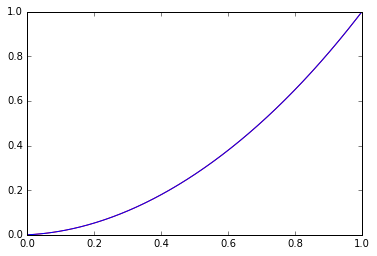

In [193]:
#Plot of the Numerical and Analytical solution 
y = np.linspace(interval[0],interval[1],partitions+1) #Plot of numerical solution
plt.plot(y,alpha,'r')
y_1 = np.arange(interval[0],interval[1],0.001)#Plot of analytical solution
plt.plot(y_1,u_anal(y_1), 'b')
plt.show()

### 1.2 Now we solve the complete problem: 
## $$ -u''+[2+\sin(u(x))]=\sin(x)$$
### In the interval $x \in [0,1]$ as a series of problems with Newton

In [194]:
# Iteration for Newton

for i in xrange(300):
    
    # Setting up the all non-linear local matrices and sides

    for e in listElements:#The matrix elements q11,q12,q21,q22 and the sides mm1,mm2 are computed with the galerkin method results
        q11 = sum([x*x*y*np.cos(alpha[e.index-1]*e.phi_i(z)+alpha[e.index]*e.phi_ii(z)) for x,y,z in zip(e.int_phi_i,e.omega,e.x_q)])
        q12 = sum([x*y*w*np.cos(alpha[e.index-1]*e.phi_i(z)+alpha[e.index]*e.phi_ii(z)) for x,y,w,z in zip(e.int_phi_i,e.int_phi_ii,e.omega,e.x_q)])
        q22 = sum([x*x*y*np.cos(alpha[e.index-1]*e.phi_i(z)+alpha[e.index]*e.phi_ii(z)) for x,y,z in zip(e.int_phi_ii,e.omega,e.x_q)])
        e.setlocalMatrix_Q(q11,q12,q12,q22)
        mm1 = sum([x*y*np.sin(alpha[e.index-1]*e.phi_i(z)+alpha[e.index]*e.phi_ii(z)) for x,y,z in zip(e.int_phi_i,e.omega,e.x_q)])
        mm2 = sum([x*y*np.sin(alpha[e.index-1]*e.phi_i(z)+alpha[e.index]*e.phi_ii(z)) for x,y,z in zip(e.int_phi_ii,e.omega,e.x_q)])
        e.setlocalside_mm(mm1,mm2)

    # Setting up the non-linear Global matrix Q and global side mm

    Q = np.zeros((partitions+1,partitions+1))
    mm = np.zeros((partitions+1,1))
    for e in listElements:# Setting up the non-linear Global matrix Q and global side mm using the contribution of each element
        Q[e.index-1][e.index-1] +=e.localMatrix_Q[0][0]
        Q[e.index-1][e.index] +=e.localMatrix_Q[0][1] 
        Q[e.index][e.index-1] +=e.localMatrix_Q[1][0]  
        Q[e.index][e.index] +=e.localMatrix_Q[1][1]  
        mm[e.index-1] += e.localside_mm[0]
        mm[e.index] += e.localside_mm[1]

    # setting up the dirichlet boundary conditions
    h_d = np.zeros((partitions+1,1))
    h_d[0]=0# boundary condition h(0)=0
    h_d[-1]=0# boundary condition h(1)=0
    b_nl=b-np.dot(A+Q, alpha_d)# Updating the local side with the boundary conditions

    #Solving the linear system with dirichlet transformed system
    Q_1=Q
    mm_1=mm
    b_2=b_nl
    Q_1 = np.delete(Q_1, (0), axis=0) #updating Q to the B.C.
    Q_1 = np.delete(Q_1, (-1), axis=0)
    Q_1 = np.delete(Q_1,(0), axis=1)
    Q_1 = np.delete(Q_1,(-1), axis=1)
    mm_1 = np.delete(mm_1, (0), axis=0) #updating mm to the B.C.
    mm_1 = np.delete(mm_1, (-1), axis=0)
    b_2 = np.delete(b_2, (0), axis=0) #updating b to the B.C.
    b_2 = np.delete(b_2, (-1), axis=0)
    h_n = np.linalg.solve(A_1+Q_1,-np.dot(A_1, alpha_0)- mm_1 + b_2 ) #solving linear system

    #appending the boundary values for dirichlet B.C.
    h_n = np.append([[h_d[0]]],h_n)
    h_n = np.append(h_n, [[h_d[-1]]])
    print  h_n
    alpha = alpha + h_n
    alphas.append(alpha)

[  0.00000000e+00   5.38801377e-05   1.07781828e-04   1.61726626e-04
   2.15736082e-04   2.69831709e-04   3.24034926e-04   3.78366943e-04
   4.32848591e-04   4.87500063e-04   5.42340550e-04   5.97387757e-04
   6.52657253e-04   7.08161652e-04   7.63909576e-04   8.19904379e-04
   8.76142601e-04   9.32612099e-04   9.89289842e-04   1.04613931e-03
   1.10310748e-03   1.16012132e-03   1.21708374e-03   1.27386906e-03
   1.33031780e-03   1.38623075e-03   1.44136247e-03   1.49541383e-03
   1.54802385e-03   1.59876059e-03   1.64711105e-03   1.69247007e-03
   1.73412818e-03   1.77125822e-03   1.80290075e-03   1.82794823e-03
   1.84512770e-03   1.85298216e-03   1.84985035e-03   1.83384501e-03
   1.80282942e-03   1.75439234e-03   1.68582106e-03   1.59407273e-03
   1.47574372e-03   1.32703709e-03   1.14372813e-03   9.21127831e-04
   6.54044405e-04   3.36742763e-04   0.00000000e+00]
[  0.00000000e+00   4.65650683e-05   9.31703178e-05   1.39855948e-04
   1.86662184e-04   2.33629262e-04   2.80797380e-0

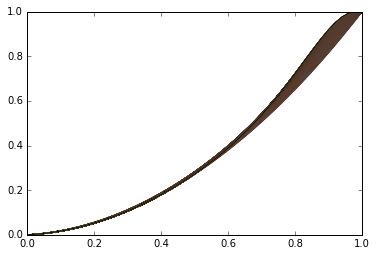

In [195]:
y = np.linspace(interval[0],interval[1],partitions+1) #Plot of numerical solution
color = ['k','r','g','b','y']
for i,j in enumerate(alphas) :
    plt.plot(y,j,color[i%5]) #Plot of numerical solution iteration 0
plt.show()

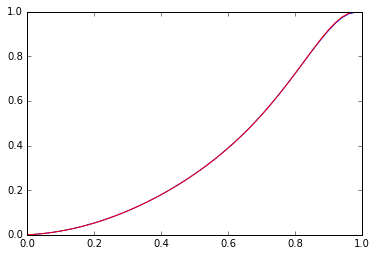

In [196]:
plt.plot(y,alphas[-20],'b')
plt.plot(y,alphas[-1],'r') #Plot of numerical solution iteration 0
plt.show()

## 1. Solution of the problem: 
# $$ -u''+[2+\sin(u(x))]=e^{\sin(x)+1}$$
## In the interval $x \in [0,1]$

### 1.1 We first solve the problem: 
## $$ -u_0''+[2+u_0(x)]=e^{\sin(x)+1}$$
### In the interval $x \in [0,1]$

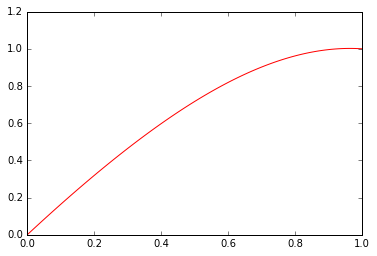

[ 0.          0.00016507  0.00033016  0.00049528  0.00066045  0.00082568
  0.00099098  0.00115636  0.00132183  0.0014874   0.00165306  0.00181881
  0.00198464  0.00215054  0.00231649  0.00248248  0.00264846  0.00281442
  0.00298032  0.00314609  0.0033117   0.00347709  0.00364219  0.00380693
  0.00397122  0.00413499  0.00429814  0.00446056  0.00462215  0.0047828
  0.00494236  0.00510072  0.00525773  0.00541325  0.00556711  0.00571915
  0.00586921  0.0060171   0.00616264  0.00630562  0.00644586  0.00658313
  0.00671724  0.00684794  0.00697501  0.00709822  0.00721733  0.00733207
  0.00744222  0.00754749  0.00764763  0.00774237  0.00783143  0.00791454
  0.00799141  0.00806176  0.0081253   0.00818173  0.00823077  0.00827212
  0.00830548  0.00833056  0.00834704  0.00835465  0.00835306  0.008342
  0.00832116  0.00829024  0.00824895  0.00819701  0.00813412  0.00806
  0.00797437  0.00787696  0.00776749  0.00764571  0.00751134  0.00736415
  0.00720388  0.0070303   0.00684318  0.0066423   0.00642

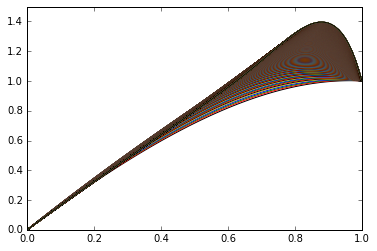

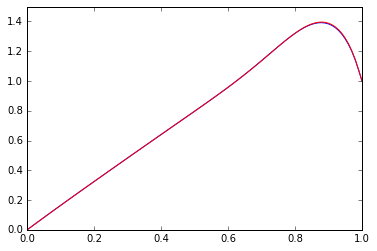

In [205]:
def setProblem():
    """Setting up of the Problem parameters"""
    interval = [0.,1.]
    return interval,lambda x: np.exp(np.sin(x)+1)
# Setting problem up and making of all  elements
interval,f = setProblem() # initialising the interval of solution and functions f(x) 
partitions = 100
listElements = [] 
for i in xrange(partitions): # Generates a list of elements to be iterated
    Elementi = Element(i+1,interval,partitions)
    listElements.append(Elementi)
# Setting up the all "constant" local matrices

for e in listElements:#The matrix elements a11,a12,a21,a22,m11,m12,m21,m22 and the sides b1,b2 are computed with the galerkin method results
    a11 = sum([x*x*y for x,y in zip(e.int_dphi_i,e.omega)])
    a12 = sum([x*y*z for x,y,z in zip(e.int_dphi_i,e.int_dphi_ii,e.omega)])
    a22 = sum([x*x*y for x,y in zip(e.int_dphi_ii,e.omega)])
    e.setlocalMatrix_A(a11,a12,a12,a22)
    m11 = sum([x*x*y for x,y in zip(e.int_phi_i,e.omega)])
    m12 = sum([x*y*z for x,y,z in zip(e.int_phi_i,e.int_phi_ii,e.omega)])
    m22 = sum([x*x*y for x,y in zip(e.int_phi_ii,e.omega)])
    e.setlocalMatrix_M(m11,m12,m12,m22)
    b1 = sum([x*y*(f(z)-2.) for x,y,z in zip(e.int_phi_i,e.omega,e.x_q)])
    b2 = sum([x*y*(f(z)-2.) for x,y,z in zip(e.int_phi_ii,e.omega,e.x_q)])
    e.setlocalside_b(b1,b2)
# Setting up the "constant" Global matrices A and M and global side b

A = np.zeros((partitions+1,partitions+1))
M = np.zeros((partitions+1,partitions+1))
b = np.zeros((partitions+1,1))
for e in listElements:# Setting up the Global matrices A and M and global side b using the contribution of each element
    A[e.index-1][e.index-1] +=e.localMatrix_A[0][0]
    A[e.index-1][e.index] +=e.localMatrix_A[0][1] 
    A[e.index][e.index-1] +=e.localMatrix_A[1][0]  
    A[e.index][e.index] +=e.localMatrix_A[1][1]
    M[e.index-1][e.index-1] +=e.localMatrix_M[0][0]
    M[e.index-1][e.index] +=e.localMatrix_M[0][1] 
    M[e.index][e.index-1] +=e.localMatrix_M[1][0]  
    M[e.index][e.index] +=e.localMatrix_M[1][1]  
    b[e.index-1] += e.localside_b[0]
    b[e.index] += e.localside_b[1]

# setting up the dirichlet boundary conditions
alpha_d = np.zeros((partitions+1,1))
alpha_d[0]=0# boundary condition u(0)=0
alpha_d[-1]=1# boundary condition u(1)=1
b_l=b-np.dot(A+M, alpha_d)# Updating the local side with the boundary conditions

#Solving the linear system with dirichlet transformed system
A_1=A
M_1=M
b_1=b_l
A_1 = np.delete(A_1, (0), axis=0) #updating A to the B.C.
A_1 = np.delete(A_1, (-1), axis=0)
A_1 = np.delete(A_1,(0), axis=1)
A_1 = np.delete(A_1,(-1), axis=1)
M_1 = np.delete(M_1, (0), axis=0) #updating M to the B.C.
M_1 = np.delete(M_1, (-1), axis=0)
M_1 = np.delete(M_1,(0), axis=1)
M_1 = np.delete(M_1,(-1), axis=1)
b_1 = np.delete(b_1, (0), axis=0) #updating b to the B.C.
b_1 = np.delete(b_1, (-1), axis=0)
alpha_0 = np.linalg.solve(A_1+M_1, b_1) #solving linear system

#appending the boundary values for dirichlet B.C.
alpha = np.append([[alpha_d[0]]],alpha_0)
alpha = np.append(alpha, [[alpha_d[-1]]])
alphas = []
alphas.append(alpha)

#Plot of the Numerical solution 
y = np.linspace(interval[0],interval[1],partitions+1) #Plot of numerical solution
plt.plot(y,alpha,'r')
plt.show()

# Iteration for Newton

for i in xrange(1000):
    
    # Setting up the all non-linear local matrices and sides

    for e in listElements:#The matrix elements q11,q12,q21,q22 and the sides mm1,mm2 are computed with the galerkin method results
        q11 = sum([x*x*y*np.cos(alpha[e.index-1]*e.phi_i(z)+alpha[e.index]*e.phi_ii(z)) for x,y,z in zip(e.int_phi_i,e.omega,e.x_q)])
        q12 = sum([x*y*w*np.cos(alpha[e.index-1]*e.phi_i(z)+alpha[e.index]*e.phi_ii(z)) for x,y,w,z in zip(e.int_phi_i,e.int_phi_ii,e.omega,e.x_q)])
        q22 = sum([x*x*y*np.cos(alpha[e.index-1]*e.phi_i(z)+alpha[e.index]*e.phi_ii(z)) for x,y,z in zip(e.int_phi_ii,e.omega,e.x_q)])
        e.setlocalMatrix_Q(q11,q12,q12,q22)
        mm1 = sum([x*y*np.sin(alpha[e.index-1]*e.phi_i(z)+alpha[e.index]*e.phi_ii(z)) for x,y,z in zip(e.int_phi_i,e.omega,e.x_q)])
        mm2 = sum([x*y*np.sin(alpha[e.index-1]*e.phi_i(z)+alpha[e.index]*e.phi_ii(z)) for x,y,z in zip(e.int_phi_ii,e.omega,e.x_q)])
        e.setlocalside_mm(mm1,mm2)

    # Setting up the non-linear Global matrix Q and global side mm

    Q = np.zeros((partitions+1,partitions+1))
    mm = np.zeros((partitions+1,1))
    for e in listElements:# Setting up the non-linear Global matrix Q and global side mm using the contribution of each element
        Q[e.index-1][e.index-1] +=e.localMatrix_Q[0][0]
        Q[e.index-1][e.index] +=e.localMatrix_Q[0][1] 
        Q[e.index][e.index-1] +=e.localMatrix_Q[1][0]  
        Q[e.index][e.index] +=e.localMatrix_Q[1][1]  
        mm[e.index-1] += e.localside_mm[0]
        mm[e.index] += e.localside_mm[1]

    # setting up the dirichlet boundary conditions
    h_d = np.zeros((partitions+1,1))
    h_d[0]=0# boundary condition h(0)=0
    h_d[-1]=0# boundary condition h(1)=0
    b_nl=b-np.dot(A+Q, alpha_d)# Updating the local side with the boundary conditions

    #Solving the linear system with dirichlet transformed system
    Q_1=Q
    mm_1=mm
    b_2=b_nl
    Q_1 = np.delete(Q_1, (0), axis=0) #updating Q to the B.C.
    Q_1 = np.delete(Q_1, (-1), axis=0)
    Q_1 = np.delete(Q_1,(0), axis=1)
    Q_1 = np.delete(Q_1,(-1), axis=1)
    mm_1 = np.delete(mm_1, (0), axis=0) #updating mm to the B.C.
    mm_1 = np.delete(mm_1, (-1), axis=0)
    b_2 = np.delete(b_2, (0), axis=0) #updating b to the B.C.
    b_2 = np.delete(b_2, (-1), axis=0)
    h_n = np.linalg.solve(A_1+Q_1,-np.dot(A_1, alpha_0)- mm_1 + b_2 ) #solving linear system

    #appending the boundary values for dirichlet B.C.
    h_n = np.append([[h_d[0]]],h_n)
    h_n = np.append(h_n, [[h_d[-1]]])
    if i%10 == 0:
        print  h_n
    alpha = alpha + h_n
    alphas.append(alpha)

ax = plt.axes(xlim=(0, 1), ylim=(0, 1.5))
y = np.linspace(interval[0],interval[1],partitions+1) #Plot of numerical solution
color = ['k','r','g','b','y']
for i,j in enumerate(alphas) :
    plt.plot(y,j,color[i%5]) #Plot of numerical solution iteration 0
plt.show()

ax = plt.axes(xlim=(0, 1), ylim=(0, 1.5))
plt.plot(y,alphas[-50],'b')
plt.plot(y,alphas[-1],'r') #Plot of numerical solution iteration 0
plt.show()